In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from string import ascii_lowercase
from matplotlib import gridspec

In [2]:
techs = ['load', 'bio', 'ror', 'off', 'on', 'pv', 'h2', 'hydro', 'bat', 'curt']

In [3]:
colors = {
    'load':  (  0/255,   0/255,   0/255),
    'bio':   ( 84/255, 130/255,  53/255),
    'bioflex': ( 84/255, 130/255,  53/255),
    'ror':   ( 31/255,  78/255, 121/255),
    'off':   ( 75/255, 145/255, 195/255),
    'on':    (153/255, 193/255, 221/255),
    'pv':    (255/255, 192/255,   0/255),
    'h2':    (112/255, 173/255,  71/255),
    'hydro': ( 46/255, 117/255, 182/255), 
    'bat':   (192/255,   0/255,   0/255),
    'curt':  (190/255, 190/255, 190/255)
}

In [4]:
names = {
    'load':  'Load',
    'bio':   'Bioenergy',
    'bioflex':   'Bio FLEX',
    'ror':   'Hydro ROR',
    'off':   'Offshore wind',
    'on':    'Onshore wind',
    'pv':    'Solar PV',
    'h2':    'Hydrogen',
    'hydro': 'Hydro DIS', 
    'bat':   'Batteries',
    'curt':  'Curtailment'
}

In [5]:
eff_discharge = {
    'hydro': 0.89,
    'bat': 0.95,
    'h2': 0.63,
    'bioflex': 1
}
eff_charge = {
    'hydro': 0.89,
    'bat': 0.95,
    'h2': 0.75,
    'bioflex': 1
}
eff_charge['h2'] * eff_discharge['h2']

0.47250000000000003

# Cost optimization

In [6]:
scenarios = {
    'cost_optimal':  'FIXEDVRE0_COSTVREdefault_COSTSTOdefault_NOLOSS0_NOCHARGELIM0_FLEXBIO0',
    'no_loss':       'FIXEDVRE1_COSTVREdefault_COSTSTOdefault_NOLOSS1_NOCHARGELIM0_FLEXBIO0',
    'no_charge_lim': 'FIXEDVRE1_COSTVREdefault_COSTSTOdefault_NOLOSS1_NOCHARGELIM1_FLEXBIO0',
}
results = {
    scenario: {
        key: pd.read_excel('results/output_1_306817_{}.xlsx'.format(filename), key, header=([1, 2] if key=='ts' else 1), index_col=0) 
        for key in (['output', 'modelstats', 'ts'])
    }
    for scenario, filename in scenarios.items()
}

In [7]:
def plot_stacked(ax, ynames, xlabels, ylabel, ymax, scenario='cost_optimal', s=1):

    output = results[scenario]['output'].fillna(0)
    
    handles, labels = [], []
    b = 0
    for tech in ['load', 'bio', 'ror', 'h2', 'hydro', 'bat', 'off', 'on', 'pv', 'curt']:
        if ynames==['Cost']:
            y = output.loc[tech, [
                'Generation cost per load (€/MWh)', 
                'Charging capacity cost per load (€/MWh)',
                'Storage capacity cost per load (€/MWh)'
            ]].sum() * 35
        else:
            y = output.loc[tech, ynames] * s
        handle = plt.bar(range(len(ynames)), y, bottom=b, color=colors[tech], label=tech,
                         hatch=r"\\" if tech in eff_charge.keys() else "")[0]
        #ax1.bar(range(1, 5), range(1, 5), color='none', edgecolor='red', hatch="/", lw=1., zorder = 0)
        handles.append(handle)
        labels.append(names[tech])
        b += y

    ax.set_xlim(-0.5, -0.5+len(ynames))
    ax.set_xticks(range(len(ynames)))
    ax.set_xticklabels(xlabels)

    ax.set_ylim(ymax=ymax)
    ax.set_ylabel(ylabel)

    plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)
    ax.set_axisbelow(True)
    
    return ax, handles, labels

In [8]:
def plot_power(ax, scenario='cost_optimal'):
    return plot_stacked(
        ax, 
        ['Supply capacity (GW)', 'Consumption capacity (GW)'],
        ['Sources', 'Sinks'],
        'Power capacity (GW)',
        ymax=430
    )

In [9]:
def plot_volume(ax, scenario='cost_optimal'):
    return plot_stacked(
        ax, 
        ['Storage capacity (TWh)'],
        ['Storage'],
        'Energy capacity (TWh)',
        ymax=63
    )

In [10]:
def plot_energy(ax, scenario='cost_optimal'):
    return plot_stacked(
        ax, 
        ['Mean energy supply (GW)', 'Mean energy consumption (GW)'],
        ['Sources', 'Sinks'],
        'Annual electricity balance (TWh)',
        ymax=900, 
        s=8.76
    )

In [11]:
def plot_cost(ax, scenario='cost_optimal'):
    return plot_stacked(
        ax, 
        ['Cost'],
        ['Cost'],
        'Cost per load (€/MWh)',
        ymax=93
    )

In [12]:
def plot_summary(scenario='cost_optimal'):
    
    fig = plt.figure(figsize=[9,4])
    
    spec = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[5, 2.5, 5, 2.5])

    handles, labels = [], []

    for i, f in enumerate([plot_power, plot_volume, plot_energy, plot_cost]):
        ax = fig.add_subplot(spec[i])
        ax, handles, labels = f(ax, scenario)
        ax.text(0.03 if i in [0,2] else 0.05, 0.97, ascii_lowercase[i], transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")

    # Finishing
    ax.legend(loc='upper center', bbox_to_anchor=(0, 1.25))
    fig.tight_layout()
    ax.legend(handles=handles[::-1], labels=labels[::-1], loc='upper center', bbox_to_anchor=(-3.2, 1.25), ncol=5)

    plt.savefig('{}.png'.format(scenario), dpi=300)

In [13]:
plt.rcParams['hatch.linewidth'] = 0.5

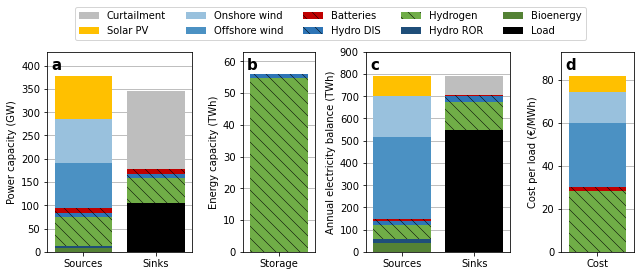

In [14]:
plot_summary('cost_optimal')

Numbers for the text

In [15]:
# Numbers for the text
output = results['cost_optimal']['output'].fillna(0)

capa_vre = output.loc[['pv', 'on', 'off'], 'Supply capacity (GW)']
print('VRE: {} GW (pv: {}, on: {}, off: {})'.format(
    capa_vre.sum().round(),
    capa_vre.round().iloc[0], 
    capa_vre.round().iloc[1], 
    capa_vre.round().iloc[2]
))

sto_discharge = output.loc[['h2', 'bat', 'hydro'], 'Supply capacity (GW)']
print('STO DISCHARGE: {} GW (h2: {}, bat: {}, hydro: {})'.format(
    sto_discharge.sum().round(),
    sto_discharge.round().iloc[0], 
    sto_discharge.round().iloc[1], 
    sto_discharge.round().iloc[2]
))

load_avg = output.loc[['load'], 'Mean energy consumption (GW)']
load_peak = output.loc[['load'], 'Consumption capacity (GW)']
print('LOAD: {} GW avg und {} GW peak (STO DISCHARGE {}% of peak)'.format(
    load_avg.round().iloc[0],
    load_peak.round().iloc[0], 
    (sto_discharge.sum()/load_peak.iloc[0]*100).round()
))

sto_charge = output.loc[['h2', 'bat', 'hydro'], 'Consumption capacity (GW)']
print('STO CHARGE: {} GW (h2: {}, bat: {}, hydro: {})'.format(
    sto_charge.sum().round(),
    sto_charge.round().iloc[0], 
    sto_charge.round().iloc[1], 
    sto_charge.round().iloc[2]
))

sto_energy = output.loc[['h2', 'bat', 'hydro'], 'Storage capacity (TWh)']
print('STO VOLUME: {} TWh (h2: {}, hydro: {}, bat: {} GWh)'.format(
    sto_energy.sum().round(1),
    sto_energy.round(1).iloc[0], 
    sto_energy.round(1).iloc[2],
    (1000 * sto_energy).round().iloc[1]
))

curt = output.loc[['curt'], 'Consumption capacity (GW)']
print('CURTAILMENT: {} GW max,'.format(
    curt.round().iloc[0]
))

VRE: 284.0 GW (pv: 92.0, on: 94.0, off: 98.0)
STO DISCHARGE: 81.0 GW (h2: 62.0, bat: 10.0, hydro: 9.0)
LOAD: 62.0 GW avg und 105.0 GW peak (STO DISCHARGE 77.0% of peak)
STO CHARGE: 72.0 GW (h2: 54.0, bat: 10.0, hydro: 8.0)
STO VOLUME: 56.1 TWh (h2: 54.8, hydro: 1.3, bat: 59.0 GWh)
CURTAILMENT: 169.0 GW max,


In [16]:
sto_energy_el = sto_energy * sto_energy.index.map(eff_discharge)
print('STO VOLUME in el. terms: {} TWh (h2: {}, hydro: {}, bat: {} GWh)'.format(
    sto_energy_el.sum().round(1),
    sto_energy_el.round(1).iloc[0], 
    sto_energy_el.round(1).iloc[2],
    (1000 * sto_energy_el).round().iloc[1]
))

print('STO VOLUME vs. LOAD: {}% of annual, {} days peak, {} days avg'.format(
    (sto_energy_el.sum() / load_avg.iloc[0] / 8.76 * 100).round(0),
    (sto_energy_el.sum() / load_peak.iloc[0] * 1000 / 24).round(0),
    (sto_energy_el.sum() / load_avg.iloc[0] * 1000 / 24).round(0)
))
#discharge = supply[['h2', 'hydro', 'bat']].sum() - hydro_natural
print('STO DURATION: {} d (h2: {} d, hydro: {} h, bat: {} h)'.format(
    (sto_energy_el.sum() / sto_discharge.sum() * 1000 / 24).round(),
    (sto_energy_el['h2'] / sto_discharge['h2'] * 1000 / 24).round(),
    (sto_energy_el['hydro'] / sto_discharge['hydro'] * 1000 / 24).round(),
    (sto_energy_el['bat'] / sto_discharge['bat'] * 1000).round(),
))

STO VOLUME in el. terms: 35.7 TWh (h2: 34.5, hydro: 1.1, bat: 56.0 GWh)
STO VOLUME vs. LOAD: 7.0% of annual, 14.0 days peak, 24.0 days avg
STO DURATION: 18.0 d (h2: 23.0 d, hydro: 5.0 h, bat: 5.0 h)


In [17]:
supply = output.loc[['bio', 'ror', 'off', 'on', 'pv', 'h2', 'hydro', 'bat'], 'Mean energy supply (GW)']
consumption = output.loc[['load', 'curt', 'h2', 'hydro', 'bat'], 'Mean energy consumption (GW)']

hydro_natural = supply['hydro'] - consumption['hydro']*0.8

pes = supply[['pv', 'on', 'off', 'bio', 'ror']].sum() + hydro_natural
print('PES: {} TWh, which is {}% of load (off: {}%, on: {}%, pv:{}%)'.format(
    (pes*8.76).round(0),
    (pes/load_avg*100).round(0).iloc[0],
    (supply['off']/pes*100).round(0),
    (supply['on']/pes*100).round(0),
    (supply['pv']/pes*100).round(0)
))

curt = consumption['curt']
charge = consumption[['h2', 'hydro', 'bat']].sum()
print('PES TO: load {} TWh ({}%), charge {} TWh ({}%), curt {} TWh ({}%)'.format(
    ((pes-curt-charge)*8.76).round(0),
    ((pes-curt-charge)/pes*100).round(0),
    (charge*8.76).round(0),
    (charge/pes*100).round(0),
    (curt*8.76).round(0),
    (curt/pes*100).round(0),
))

discharge = supply[['h2', 'hydro', 'bat']].sum() - hydro_natural
print('STO SUPPLY: {} TWh ({}% of load)'.format(
    (discharge*8.76).round(0),
    (discharge/load_avg*100).round(0).iloc[0]
))

PES: 699.0 TWh, which is 128.0% of load (off: 53.0%, on: 26.0%, pv:13.0%)
PES TO: load 455.0 TWh (65.0%), charge 160.0 TWh (23.0%), curt 84.0 TWh (12.0%)
STO SUPPLY: 92.0 TWh (17.0% of load)


# Time series analysis

In [18]:
tsa = pd.read_excel('results/20210610_All_DE.xlsx')

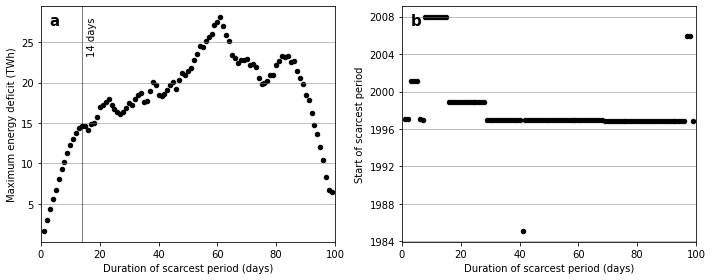

In [19]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)

df = tsa[tsa['Days'].isin(range(100))]

plt.scatter(df['Days'], df['NDF_E TWh'], color='k', s=20)
plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)

ax1.set_xlim([0,100])
ax1.set_xlabel('Duration of scarcest period (days)')

ax1.set_ylabel('Maximum energy deficit (TWh)')

ax1.axvline(14, color='k', linewidth=.5)
ax1.text(15.5, 23.5, '14 days', rotation=90)

ax1.text(0.03, 0.97, 'a', transform=ax1.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")

ax2 = fig.add_subplot(122)

plt.scatter(df['Days'], df['DIFFWHEN'], color='k', s=20)
plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)

ax2.set_xlim([0,100])
ax2.set_xlabel('Duration of scarcest period (days)')

ax2.set_ylabel('Start of scarcest period')

ax2.text(0.03, 0.97, 'b', transform=ax2.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")


fig.tight_layout()
plt.savefig('TSA.png', dpi=300)

In [20]:
ts = {scenario: r['ts'].fillna(0) for scenario, r in results.items()}
for tss in ts.values():
    tss.index = pd.DatetimeIndex([pd.Timestamp(1982,1,1)+pd.Timedelta(hours=h-1) for h in tss.index])

In [21]:
def plot_energy_balance(ax, df, bbox_to_anchor=(1.1, 0.5)):
    
    supply = df['supply']
    consumption = df['consumption']
    
    x = df.index
    b_pos = 0
    b_neg = 0

    labels = techs
    handles = []
    for tech in techs:
        pos = supply[tech] if tech in supply.columns else 0
        neg = -consumption[tech] if tech in consumption.columns else 0
        plt.fill_between(x, b_pos, b_pos+pos, label=tech, color=colors[tech], edgecolor='k', linewidth=0,
                         hatch=r"\\" if tech in eff_charge.keys() else "")
        handle = plt.fill_between(x, b_neg, b_neg+neg, label=tech, color=colors[tech], edgecolor='k', linewidth=0,
                                 hatch=r"\\" if tech in eff_charge.keys() else "")
        b_pos += pos
        b_neg += neg
        handles.append(handle)

    # X axis
    ax.set_xlim(df.index[[0,-1]])
    

    # Y axis
    ax.set_ylim([-250,250])
    ylabel = 'Electricity balance (GW)'
    ax.set_ylabel(ylabel)

    # Grid
    plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)

    plt.legend(labels=[names[x] for x in labels[::-1]], handles=handles[::-1], 
               loc='center', bbox_to_anchor=bbox_to_anchor)
    #plt.title(str(focus_region) + ' in scenario ' + scenario + ': ' + 'from hour ' + str(hour_range[0]) + ' to hour ' + str(hour_range[1]))

    return ax

In [26]:
def plot_worst(n, plot_period=None, figsize=(7, 5), bbox_to_anchor=(1.2, 0.5), xticks=['2007-12-16'], xticklabels=['December 2007']):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    df = tsa[tsa['Days']==n]
    start = df['DIFFWHEN'].iloc[0]
    end = start + pd.Timedelta(days=n)
    t14 = ts['cost_optimal'].loc[start:end]
    if plot_period:
        t14p = ts['cost_optimal'].loc[plot_period[0]:plot_period[1]]
    else:
        t14p = ts['cost_optimal'].loc[(start-pd.Timedelta(days=10)):(end+pd.Timedelta(days=10))]
    ax = plot_energy_balance(ax, t14p, bbox_to_anchor=bbox_to_anchor)

    ax.axvline(start, color='k', linewidth=0.8)
    ax.axvline(end, color='k', linewidth=0.8)

    h = 210
    ax.annotate('', xy=(start, h), xytext=(end, h), arrowprops=dict(arrowstyle="<->"))
    ax.text(start + (end-start)/2, h+6, 'Scarcest {} days'.format(n), ha='center')

    start_of_months = pd.date_range(start=t14p.index[0], end=t14p.index[-1], freq='m')
    ax.set_xticks(start_of_months + pd.Timedelta(days=1))
    ax.set_xticklabels('')

    ax.set_xticks(xticks, minor=True)
    ax.set_xticklabels(xticklabels, minor=True)

    print('Energy deficit: {} TWh ({}% or {} days of laod)'.format(
        energy_deficit(t14),
        round(energy_deficit(t14) / load_avg.iloc[0] / 8.76 * 100, 1),
        round(energy_deficit(t14) / load_avg.iloc[0] * 1000 / 24, 1)
    ))

    fig.tight_layout()
    plt.savefig('Scarcest {}.png'.format(n), dpi=300)

In [27]:
def energy_deficit(df, loss=True):
    eff = eff_discharge['hydro'] if loss else 1
    return round(
        df['consumption']['load'].sum() 
        - df['supply'][['pv', 'on', 'off', 'bio', 'ror', 'hydro']].sum().sum() 
        + df['consumption']['hydro'].sum() * eff**2
        + df['soc']['hydro'][0] * eff
    )/1000

Energy deficit: 12.445 TWh (2.3% or 8.3 days of laod)


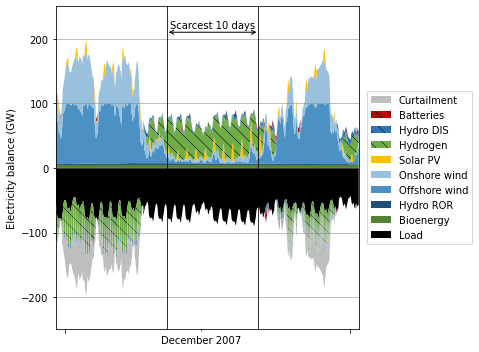

In [28]:
plot_worst(
    10, 
    plot_period=('2007-11-30 03:00:00','2008-01-02 03:00:00')
)

Energy deficit: 28.059 TWh (5.1% or 18.7 days of laod)


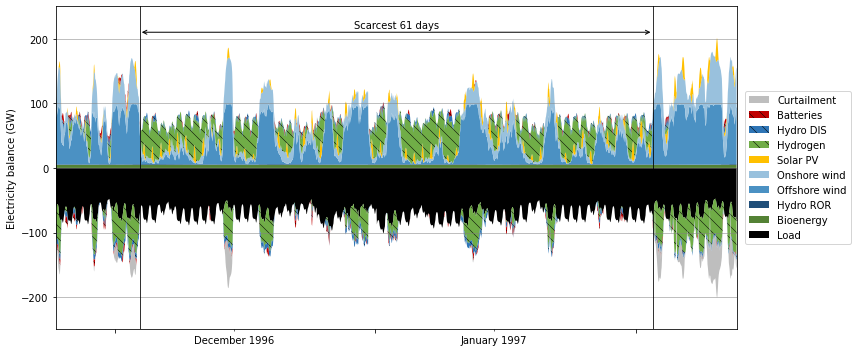

In [29]:
plot_worst(
    61, 
    figsize=(12, 5), bbox_to_anchor=(1.09, 0.5), 
    xticks=['1996-12-16', '1997-01-16'], xticklabels=['December 1996', 'January 1997']
)

# Bridging the gap

In [30]:
scenarios = ['cost_optimal', 'no_loss', 'no_charge_lim']
sto_volume = pd.concat(
    [results[scenario]['output']['Storage capacity (TWh)'] for scenario in scenarios],
    axis=1, keys=scenarios
).dropna()

sto_volume['el_equivalent'] = sto_volume['cost_optimal'] * sto_volume.index.map(eff_discharge)
sto_volume = sto_volume[['cost_optimal', 'el_equivalent', 'no_loss', 'no_charge_lim']]

sto_volume

,cost_optimal,el_equivalent,no_loss,no_charge_lim
hydro,1.280000,1.139200,1.280000,1.280000
bat,0.058701,0.055766,0.014729,0.008064
h2,54.790654,34.518112,30.948458,26.801980


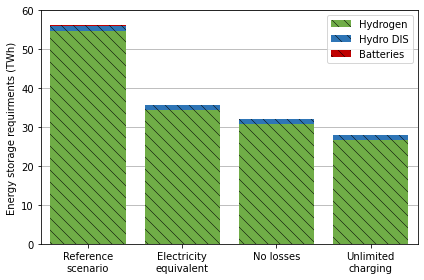

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

ynames = ['Reference\nscenario', 'Electricity\nequivalent', 'No losses', 'Unlimited\ncharging']

handles, labels = [], []
b = 0
for tech in ['h2', 'hydro', 'bat']:
    y = sto_volume.loc[tech] #* s
    handle = plt.bar(range(len(ynames)), y, bottom=b, color=colors[tech], label=tech, hatch=r"\\")[0]
    handles.append(handle)
    labels.append(names[tech])
    b += y

ax.set_xlim(-0.5, -0.5+len(ynames))
ax.set_xticks(range(len(ynames)))
ax.set_xticklabels(ynames)

ax.set_ylim(ymax=60)
ax.set_ylabel('Energy storage requirments (TWh)')

plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)
ax.set_axisbelow(True)

ax.legend(handles, labels)

fig.tight_layout()
plt.savefig('Bridging the gap.png', dpi=300)

Periods when storage is fully used:

In [32]:
scenario = 'cost_optimal'

Times when all storage is fully charged:

In [33]:
ts[scenario]['soc'].sum(axis=1).sort_values(ascending=False)[:10]

1995-10-09 23:00:00    56129.354773
2002-07-25 15:00:00    56129.354773
1996-11-12 03:00:00    56129.354773
1995-10-10 00:00:00    56129.354773
2002-07-25 16:00:00    56128.428487
1996-11-12 02:00:00    56127.995964
1996-11-12 04:00:00    56127.122442
1995-10-10 01:00:00    56126.749522
1996-11-12 01:00:00    56125.760267
2002-07-25 14:00:00    56124.733134
dtype: float64

There are three periods:

In [34]:
tsx = {}
for i, j in enumerate([1,2,3]):   
    start = ts[scenario]['soc'].sum(axis=1).sort_values(ascending=False).index[j]
    tmp = ts[scenario].loc[start:]
    end = tmp[tmp['soc'].sum(axis=1)==0].index[0]
    tsx[i] = tmp.loc[:end]

In [35]:
for tx in tsx.values():
    print('Period: {} to {}'.format(tx.index[0], tx.index[-1]))
    print('Duration: {} days'.format(round(float(len(tx))/24),0))
    t = tx[tx['consumption']['curt']>0]
    print('Hours with curtailment: {}'.format(len(t)))
    t1 = t[t['consumption']['h2']<ts[scenario]['consumption']['h2'].max()]
    print('Of which hours when storage is not fully used: {}'.format(len(t1)))

Period: 2002-07-25 15:00:00 to 2003-12-12 18:00:00
Duration: 505 days
Hours with curtailment: 1391
Of which hours when storage is not fully used: 0
Period: 1996-11-12 03:00:00 to 1997-02-03 19:00:00
Duration: 84 days
Hours with curtailment: 110
Of which hours when storage is not fully used: 0
Period: 1995-10-10 00:00:00 to 1997-02-03 19:00:00
Duration: 483 days
Hours with curtailment: 1295
Of which hours when storage is not fully used: 1


Period 1 is non-binding. Period 3 includes period 2. So period 2 is the worst period.

In [36]:
tsx = {'cost_optimal': tsx[1]}

<AxesSubplot:>

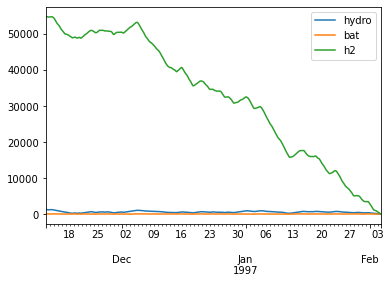

In [37]:
tsx['cost_optimal']['soc'].plot()

In [38]:
temp = tsx['cost_optimal']['soc']
temp.loc[temp.index.year==1997]

,hydro,bat,h2
1997-01-01 00:00:00,918.872513,58.700906,32469.579549
1997-01-01 01:00:00,923.473194,58.700906,32469.579549
1997-01-01 02:00:00,927.297511,58.700906,32469.579549
1997-01-01 03:00:00,928.265829,58.700906,32469.579549
1997-01-01 04:00:00,928.265829,58.700906,32462.858914
...,...,...,...
1997-02-03 15:00:00,39.578403,0.000000,107.843836
1997-02-03 16:00:00,29.683802,0.000000,64.294103
1997-02-03 17:00:00,19.789202,0.000000,28.459082
1997-02-03 18:00:00,9.894601,0.000000,4.021053


No losses

In [39]:
scenario = 'no_loss'

Times when all storage is fully charged:

In [40]:
ts[scenario]['soc'].sum(axis=1).sort_values(ascending=False)[:10]

1996-11-12 03:00:00    32243.187602
1996-12-04 20:00:00    32243.187602
1996-11-13 14:00:00    32243.187602
1996-11-13 13:00:00    32243.004856
1996-11-13 12:00:00    32242.045720
1996-11-12 02:00:00    32241.755292
1996-12-04 19:00:00    32241.622866
1996-11-12 04:00:00    32241.069827
1996-11-12 01:00:00    32239.398660
1996-11-13 15:00:00    32238.076471
dtype: float64

The first period includes the other periods.

In [41]:
start = ts[scenario]['soc'].sum(axis=1).sort_values(ascending=False).index[1]
tmp = ts[scenario].loc[start:]
end = tmp[tmp['soc'].sum(axis=1)==0].index[0]
tsx[scenario] = tmp.loc[:end]

No charging limit

In [42]:
scenario = 'no_charge_lim'

Times when all storage is fully charged:

In [43]:
ts[scenario]['soc'].sum(axis=1).sort_values(ascending=False)[:10]

1996-12-04 20:00:00    28090.043370
1996-12-04 19:00:00    28088.478634
1996-12-04 21:00:00    28084.487733
1996-12-04 18:00:00    28074.277829
1996-12-04 22:00:00    28070.801225
1996-12-04 23:00:00    28055.509427
1996-12-04 17:00:00    28050.765130
1996-12-05 00:00:00    28033.774781
1996-12-04 16:00:00    28023.563618
1996-12-05 01:00:00    28005.768863
dtype: float64

There is only one time when storage is fully charged.

In [44]:
start = ts[scenario]['soc'].sum(axis=1).sort_values(ascending=False).index[0]
tmp = ts[scenario].loc[start:]
end = tmp[tmp['soc'].sum(axis=1)==0].index[0]
tsx[scenario] = tmp.loc[:end]

Characteristics:

In [45]:
for scenario, t in tsx.items():
    print(scenario)
    print('{} to {}: {} days'.format(t.index[0], t.index[-1], t.index[-1] - t.index[0]))
    print('Energy deficit: {} TWh'.format(energy_deficit(t, loss=(scenario=='cost_optimal'))))

cost_optimal
1996-11-12 03:00:00 to 1997-02-03 19:00:00: 83 days 16:00:00 days
Energy deficit: 23.34 TWh
no_loss
1996-12-04 20:00:00 to 1997-02-03 19:00:00: 60 days 23:00:00 days
Energy deficit: 28.088 TWh
no_charge_lim
1996-12-04 20:00:00 to 1997-02-03 19:00:00: 60 days 23:00:00 days
Energy deficit: 28.089 TWh


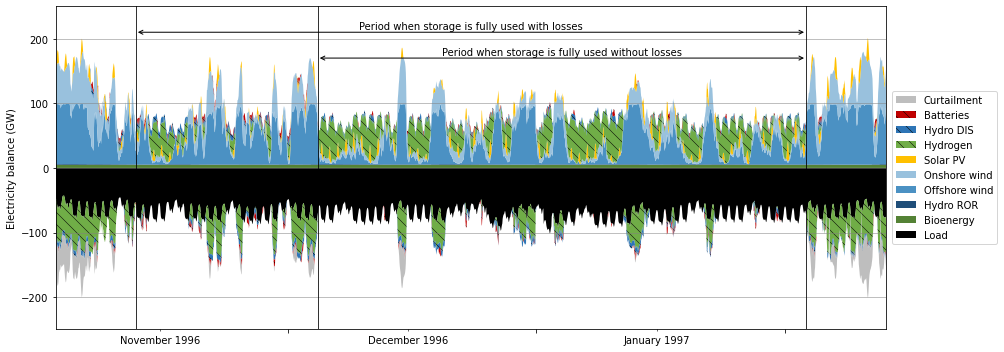

In [46]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)

tsp = ts['cost_optimal'].loc[
    (tsx['cost_optimal'].index[0] - pd.Timedelta('10d')):(tsx['cost_optimal'].index[-1] + pd.Timedelta('10d'))
]

ax = plot_energy_balance(ax, tsp, bbox_to_anchor=(1.07, 0.5))

start = tsx['cost_optimal'].index[0]
end = tsx['cost_optimal'].index[-1]

ax.axvline(start, color='k', linewidth=0.8)
ax.axvline(end, color='k', linewidth=0.8)

h = 210
ax.annotate('', xy=(start, h), xytext=(end, h), arrowprops=dict(arrowstyle="<->"))
ax.text(start + (end-start)/2, h+5, 'Period when storage is fully used with losses', ha='center')

start = tsx['no_loss'].index[0]
ax.axvline(start, color='k', linewidth=0.8)

h = 170
ax.annotate('', xy=(start, h), xytext=(end, h), arrowprops=dict(arrowstyle="<->"))
ax.text(start + (end-start)/2, h+5, 'Period when storage is fully used without losses', ha='center')

h = 100
worst_hour = pd.Timestamp('')
#ax.annotate('scarcest day', xy=(worst_day, h), xytext=('1997-01-03 18:00', h+30), arrowprops=dict(arrowstyle="->"))

start_of_months = pd.date_range(start=tsp.index[0], end=tsp.index[-1], freq='m')
ax.set_xticks(start_of_months + pd.Timedelta(days=1))
ax.set_xticklabels('')

mid_of_months = start_of_months - pd.Timedelta(days=15)
ax.set_xticks(mid_of_months, minor=True)
ax.set_xticklabels(['November 1996', 'December 1996', 'January 1997'], minor=True)

#plt.grid(axis='x', zorder=0, color='grey', linewidth=.5)

fig.tight_layout()
plt.savefig('Worst energy balance.png', dpi=300)

# Flexible bioenergy

In [47]:
output_flexbio = {
    0: results['cost_optimal']
}
for i in range(1,6):
    output_flexbio[i] = {
        key: pd.read_excel(
            'results/output_1_306817_FIXEDVRE0_COSTVREdefault_COSTSTOdefault_NOLOSS0_NOCHARGELIM0_FLEXBIO{}.xlsx'.format(
                i
            ), 
            key, header=([1, 2] if key=='ts' else 1), index_col=0
        ) 
        for key in (['output', 'modelstats', 'ts'])
    }

In [48]:
output_flexbio[0] = results['cost_optimal']

In [49]:
mapping = {
    'volume': 'Storage capacity (TWh)',
    'charging': 'Consumption capacity (GW)',
    'discharging': 'Supply capacity (GW)',
}

sto_flexbio = {
    k: pd.concat(
        [value['output'].loc[['h2', 'hydro', 'bat', 'bioflex'], v].fillna(0) for value in output_flexbio.values()],
        axis=1, keys=[2*key for key in output_flexbio.keys()]
    ).dropna()
    for k, v in mapping.items()
}

sto_flexbio['volume_el_eq'] = pd.concat(
    [col * col.index.map(eff_discharge) for label, col in sto_flexbio['volume'].items()],
    axis=1, keys=sto_flexbio['volume'].columns
).dropna()

sto_flexbio['VRE capacity'] = pd.concat(
    [value['output'].loc[['pv', 'on', 'off'], 'Supply capacity (GW)'] for value in output_flexbio.values()],
    axis=1, keys=[2*key for key in output_flexbio.keys()]
).dropna()

sto_flexbio

{'volume':                 0          2          4          6          8          10
 h2       54.790654  52.346131  49.471631  47.571206  46.105517  46.345847
 hydro     1.280000   1.280000   1.280000   1.280000   1.280000   1.280000
 bat       0.058701   0.053287   0.055135   0.054496   0.054130   0.054321
 bioflex   0.000000   2.000000   4.000000   6.000000   8.000000  10.000000,
 'charging':                 0          2          4          6          8          10
 h2       53.760525  45.500064  46.360415  46.919685  48.905040  48.941297
 hydro     7.960000   7.960000   7.960000   7.960000   7.960000   7.960000
 bat      10.463588   9.828878  10.045385   9.953745   9.899853   9.908541
 bioflex   0.000000   4.597704   4.597704   4.597704   4.597704   4.597704,
 'discharging':                 0          2          4          6          8          10
 h2       62.173651  58.309867  58.085195  58.153495  58.201615  58.195109
 hydro     8.850000   8.850000   8.850000   8.850000   8.8500

C:\Users\olive\Miniconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


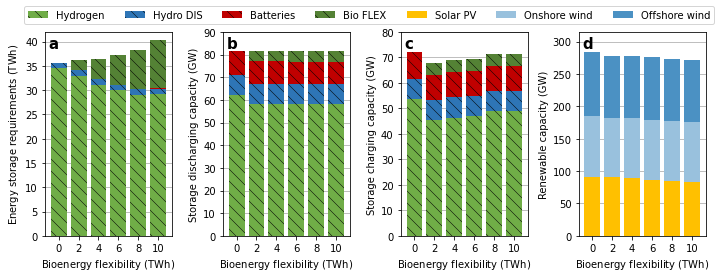

In [50]:
fig = plt.figure(figsize=(10, 4))

handles, labels = [], []


# Storage volume

ax = fig.add_subplot(141)

handles, labels = [], []
b = 0
for tech in ['h2', 'hydro', 'bat', 'bioflex']:
    y = sto_flexbio['volume_el_eq'].loc[tech]
    handle = plt.bar(range(len(y)), y, bottom=b, color=colors[tech], label=tech, hatch=r"\\")[0]
    handles.append(handle)
    labels.append(names[tech])
    b += y
    
ax.set_xticks(range(len(y.index)))
ax.set_xticklabels(y.index)

ax.set_xlabel(r'Bioenergy flexibility ($\rm{TWh}$)')
ax.set_ylabel(r'Energy storage requirements ($\rm{TWh}$)')

ax.set_ylim([0,42])
ax.text(0.03, 0.98, 'a', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")

plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)
ax.set_axisbelow(True)


# Storage discharging

ax = fig.add_subplot(142)

b = 0
for tech in ['h2', 'hydro', 'bat', 'bioflex']:
    y = sto_flexbio['discharging'].loc[tech]
    handle = plt.bar(range(len(y)), y, bottom=b, color=colors[tech], label=tech, hatch=r"\\")[0]
    b += y

ax.set_xticks(range(len(y.index)))
ax.set_xticklabels(y.index)

ax.set_xlabel(r'Bioenergy flexibility ($\rm{TWh}$)')
ax.set_ylabel('Storage discharging capacity (GW)')

ax.set_ylim([0,90])
ax.text(0.03, 0.98, 'b', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")

plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)
ax.set_axisbelow(True)


# Storage charging

ax = fig.add_subplot(143)

b = 0
for tech in ['h2', 'hydro', 'bat', 'bioflex']:
    y = sto_flexbio['charging'].loc[tech]
    handle = plt.bar(range(len(y)), y, bottom=b, color=colors[tech], label=tech, hatch=r"\\")[0]
    b += y

ax.set_xticks(range(len(y.index)))
ax.set_xticklabels(y.index)

ax.set_xlabel(r'Bioenergy flexibility ($\rm{TWh}$)')
ax.set_ylabel('Storage charging capacity (GW)')

ax.set_ylim([0,80])
ax.text(0.03, 0.98, 'c', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")

plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)
ax.set_axisbelow(True)


# VRE capacity

ax = fig.add_subplot(144)

b = 0
for tech in ['pv', 'on', 'off']:
    y = sto_flexbio['VRE capacity'].loc[tech]
    handle = plt.bar(range(len(y)), y, bottom=b, color=colors[tech], label=tech)[0]
    handles.append(handle)
    labels.append(names[tech])
    b += y

ax.set_xticks(range(len(y.index)))
ax.set_xticklabels(y.index)

ax.set_xlabel(r'Bioenergy flexibility ($\rm{TWh}$)')
ax.set_ylabel('Renewable capacity (GW)')

ax.set_ylim([0,315])
ax.text(0.03, 0.98, 'd', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight="bold")

plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)
ax.set_axisbelow(True)


# Legend

ax.legend(loc='upper center', bbox_to_anchor=(0, 1.15))
fig.tight_layout()
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(-1.65, 1.15), ncol=7)


fig.tight_layout()
plt.savefig('Bioflex.png', dpi=300)

In [51]:
ts = {scenario: r['ts'].fillna(0) for scenario, r in output_flexbio.items()}

In [52]:
for tss in ts.values():
    tss.index = pd.DatetimeIndex([pd.Timestamp(1982,1,1)+pd.Timedelta(hours=h-1) for h in tss.index])

Times when all storage is fully charged:

In [53]:
for i in range(6):
    print(ts[i]['soc'].sum(axis=1).sort_values(ascending=False)[:5])

1995-10-09 23:00:00    56129.354773
2002-07-25 15:00:00    56129.354773
1996-11-12 03:00:00    56129.354773
1995-10-10 00:00:00    56129.354773
2002-07-25 16:00:00    56128.428487
dtype: float64
1995-10-10 00:00:00    55679.417704
2002-07-25 14:00:00    55679.417704
1996-11-12 03:00:00    55679.417704
2002-07-25 15:00:00    55679.417704
1996-11-12 02:00:00    55679.287675
dtype: float64
1995-10-10 00:00:00    54806.765723
1996-11-12 03:00:00    54806.765723
2002-07-25 15:00:00    54806.765723
1996-11-12 02:00:00    54806.379125
1996-11-12 01:00:00    54805.050347
dtype: float64
1996-11-12 03:00:00    54905.702409
2002-07-25 15:00:00    54905.702409
1995-10-10 00:00:00    54905.702409
1996-11-12 02:00:00    54905.045225
1996-11-12 01:00:00    54903.450171
dtype: float64
1995-10-10 00:00:00    55439.647580
2002-07-25 15:00:00    55439.647580
2002-07-25 16:00:00    55436.918180
1995-10-10 01:00:00    55436.664395
2002-07-25 14:00:00    55436.350796
dtype: float64
1995-10-10 00:00:00    57

In [54]:
tsx = {}
for i, tx in ts.items():   
    start = tx['soc'].sum(axis=1).sort_values(ascending=False).index[2 if i<2 else 0]
    tmp = tx.loc[start:]
    end = tmp[tmp['soc'].sum(axis=1)==0].index[0]
    tsx[i] = tmp.loc[:end]

In [55]:
for i, tx in tsx.items():
    print(i) 
    print('Period: {} to {}'.format(tx.index[0], tx.index[-1]))
    print('Duration: {} days'.format(round(float(len(tx))/24),0))
    t = tx[tx['consumption']['curt']>0]
    print('Hours with curtailment: {}'.format(len(t)))
    t1 = t[t['consumption']['h2']<ts[i]['consumption']['h2'].max()]
    t1 = t[t['consumption']['h2']<ts[i]['consumption']['h2'].max()]
    print('Of which hours when storage is not fully used: {}'.format(len(t1)))

0
Period: 1996-11-12 03:00:00 to 1997-02-03 19:00:00
Duration: 84 days
Hours with curtailment: 110
Of which hours when storage is not fully used: 0
1
Period: 1996-11-12 03:00:00 to 1997-02-03 19:00:00
Duration: 84 days
Hours with curtailment: 113
Of which hours when storage is not fully used: 0
2
Period: 1995-10-10 00:00:00 to 1997-02-03 19:00:00
Duration: 483 days
Hours with curtailment: 1299
Of which hours when storage is not fully used: 0
3
Period: 1996-11-12 03:00:00 to 1997-02-03 19:00:00
Duration: 84 days
Hours with curtailment: 109
Of which hours when storage is not fully used: 0
4
Period: 1995-10-10 00:00:00 to 1997-02-03 19:00:00
Duration: 483 days
Hours with curtailment: 1166
Of which hours when storage is not fully used: 0
5
Period: 1995-10-10 00:00:00 to 1997-02-03 19:00:00
Duration: 483 days
Hours with curtailment: 1146
Of which hours when storage is not fully used: 0


## Single-year vs. multiply-year optimization

In [56]:
years = range(1982, 2016)

In [57]:
yearly_output = {}
for year in years:
    start = (dt.date(year=year, day=1, month=7) - dt.date(year=1982, day=1, month=1)).days * 24 + 1
    end = (dt.date(year=year+1, day=1, month=7) - dt.date(year=1982, day=1, month=1)).days * 24
   
    yearly_output[year] = pd.read_excel(
        'results/output_{}_{}_FIXEDVRE0_COSTVREdefault_COSTSTOdefault_NOLOSS0_NOCHARGELIM0_FLEXBIO0.xlsx'.format(start, end), 
        'output', header=1, index_col=0
    ) 

In [58]:
yearly_normalized = pd.concat({
    year: yearly_output[year]/results['cost_optimal']['output']
    for year in years
})
yearly_normalized['System cost per load (€/MWh)'] = yearly_normalized['System cost per load (€/MWh)'] / 35

In [59]:
names2 = {
    'load':  'Cost',
    'off':   'Wind\noffshore',
    'on':    'Wind\nonshore',
    'pv':    'Solar\nPV',
    'h2':    'Hydrogen',
    'bat':   'Batteries'
}
colors2 = {
    value: colors[key]
    for key, value in names2.items()
}

In [60]:
yearly_normalized['Mean energy supply (GW)'] / yearly_normalized['Supply capacity (GW)']

1982  pv         0.978369
      on         1.076137
      off        1.019669
      bio        1.000000
      ror        0.885434
                   ...   
2015  bat        1.796399
      h2         1.232015
      bioflex         NaN
      load            NaN
      curt            NaN
Length: 374, dtype: float64

In [61]:
data = {}
for key, items in {
    'Renewable\ncapacity': ('Supply capacity (GW)', ['pv', 'on', 'off']),
    'Storage\ndischarging': ('Supply capacity (GW)', ['h2', 'bat']),
    'Storage\ncharging': ('Consumption capacity (GW)', ['h2', 'bat']),
    'Storage\nenergy': ('Storage capacity (TWh)', ['h2', 'bat']),
    'Cost': ('System cost per load (€/MWh)', ['load'])
}.items():
    df = yearly_normalized[items[0]].unstack()
    df = df[items[1]].stack()
    df = pd.DataFrame({
        'Normalized results': df,
        'tech': df.index.get_level_values(1).map(names2)
    })
    data[key] = df

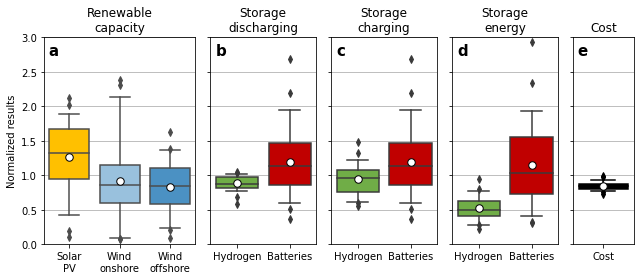

In [62]:
fig = plt.figure(figsize=[9,4])
    
spec = gridspec.GridSpec(ncols=5, nrows=1, width_ratios=[10, 7, 7, 7, 4])

ax = {}
for i, (key, df) in enumerate(data.items()):
    ax[i] = fig.add_subplot(spec[i])
    sns.boxplot(
        x='tech', 
        y='Normalized results', 
        data=df, 
        whis=[5, 95], 
        showmeans=True, 
        meanprops={
            "marker":"o",
            "markerfacecolor":"white", 
            "markeredgecolor":"black",
            "markersize":"7.5"
        },
        palette=colors2, 
        saturation=1
    )
    
    ax[i].set_title(key)
    ax[i].set_xlabel('')
    ax[i].set_ylim(0, 3)
    
    plt.grid(axis='y', zorder=0, color='grey', linewidth=.5)
    ax[i].set_axisbelow(True)
    
    ax[i].text(0.03 if i==0 else (0.07 if i==4 else 0.05), 0.97, ascii_lowercase[i], transform=ax[i].transAxes, fontsize=15, verticalalignment='top', fontweight="bold")
    
for i in range(1, 5):
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([])
    
fig.tight_layout()
plt.savefig('Single years.png', dpi=300)

In [63]:
tmp = data['Storage\nenergy']
tmp.loc[tmp.index.get_level_values(1)=='h2'].sort_values(
    'Normalized results', ascending=False
).head(5)

,,Normalized results,tech
1996,h2,0.943661,Hydrogen
1984,h2,0.806516,Hydrogen
2005,h2,0.771607,Hydrogen
1986,h2,0.754589,Hydrogen
1987,h2,0.731891,Hydrogen


In [64]:
tmp = data['Cost']
tmp.loc[tmp.index.get_level_values(1)=='load'].sort_values(
    'Normalized results', ascending=False
).head(5)

,,Normalized results,tech
1996,load,0.990408,Cost
2005,load,0.971504,Cost
2002,load,0.924371,Cost
1984,load,0.915784,Cost
2009,load,0.913590,Cost


In [65]:
yearly_output[1996]

,Mean energy supply (GW),Mean energy consumption (GW),Supply capacity (GW),Consumption capacity (GW),Storage capacity (TWh),Generation cost per load (€/MWh),Charging capacity cost per load (€/MWh),Storage capacity cost per load (€/MWh),System cost per load (€/MWh)
pv,7.485024,NaN,66.335343,NaN,NaN,5.425460,NaN,NaN,NaN
on,23.156518,NaN,108.030816,NaN,NaN,16.303035,NaN,NaN,NaN
off,40.415635,NaN,99.394145,NaN,NaN,29.999334,NaN,NaN,NaN
bio,4.597704,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
ror,1.629742,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
hydro,2.689375,3.361719,8.850000,7.960000,1.280000,NaN,NaN,NaN,NaN
bat,0.760022,0.844469,8.757267,8.757267,0.045402,0.163148,NaN,1.057303,NaN
h2,9.469775,18.789235,63.581054,60.585238,51.703818,8.475246,4.845545,14.636641,NaN
bioflex,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
load,NaN,63.090243,NaN,101.191000,NaN,NaN,NaN,NaN,80.905648
